In [1]:
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
from matplotlib.gridspec import GridSpec
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split as tts

import src.load as load
from src.utils.plots import dotplot, despine_all
from src import markers_from_solution
from src.utils.general import load_reports

In [2]:
dataset = Path('HCA')
rs = 43
root = 'data' / dataset / 'RS' / f'rs{rs}'
imdir_png = 'data' / dataset / 'images/png'
imdir_svg = 'data' / dataset / 'images/svg'

In [ ]:
# Load data
adata, key = load.dataset(
    str(dataset),
    filter_genes=True, # set to true for MC, HCA, false for IPF
    normalize=True,
    log=True,
    high_var=True, # set to true for HCA, false for MC, IPF
    scale=True,
)
adata = load.remove_low_count_ct(adata, key, 50)
x_train, x_test = tts(adata, random_state=rs, stratify=adata.obs[key], train_size=0.5)
print("Range:", adata.X.max() - adata.X.min())
print(x_train.shape, x_test.shape)

In [4]:
methods = {
    'GreedyCover': 'G-PC (ours)',
    'CrossEntropy': 'CEM-PC (ours)',
    'DT': 'Decision Tree',
    'TopDE': 'Top DE',
    'ReliefF': 'ReliefF',
    'Fval': 'F value',
    'MI': 'Mutual Information',
    'mRMR': 'mRMR',
}

method_list = list(methods.keys())
labels = list(methods.values())
reports = load_reports(root, lreports=True, method_list=method_list)

Set key='celltype' or key='tissue' if wish to find markers only for that class

In [5]:
# v = 0 if 'greedy' and 2 if 'DT'
v = 0
solution = reports[v]['8']['solution'] # load greedy cover solution
print(f'{len(solution)=}')
markers = markers_from_solution(x_train, key=key, solution=solution)

len(solution)=204


<h2>GSEA</h2>

In [ ]:
i = 0 # phenotype index
phenotype = list(markers.keys())[i]
genes = markers[phenotype].tolist()
print(phenotype, genes)

enr = gp.enrichr(
    gene_list=genes,
    gene_sets=["HuBMAP_ASCTplusB_augmented_2022"],
    outdir=None,
    no_plot=True,
    cutoff=0.1
)
res = enr.results
res.drop(['Gene_set', 'Old P-value', 'Old Adjusted P-value'],
          axis=1, inplace=True, errors='ignore')
res.rename(columns={'P-value': 'pval',
                    'Adjusted P-value': 'qval'},
           inplace=True)

res.sort_values(by=['qval'], inplace=True)
print()
# res[:50]
for index, row in res[:400].iterrows():
    print(row['Term'], row['qval'], row['Genes'], row['Overlap'])

<h2>Plot Phenotype P-values</h2>

In [6]:
def get_df(f1, f2, x):
    with open('data' / dataset / f1, 'r') as f:
        gpc = json.load(f)
    with open('data' / dataset / f2, 'r') as f:
        dt = json.load(f)
    
    df = pd.DataFrame()
    df[x] = list(gpc.keys()) + list(dt.keys())
    df['p-value'] = np.asarray(list(gpc.values()) + list(dt.values()))
    df['p-value'] = -np.log10(df['p-value'])
    df['method'] = ['G-PC (ours)'] * len(gpc) + ['Decision Tree'] * len(dt)
    return df

In [11]:
def barplot(df, ax, x, palette='Set2'):
    sns.barplot(
        x=x,
        y='p-value',
        hue='method',
        data=df,
        ax=ax,
        palette=palette,
    )
    ax.tick_params('x', rotation=90, labelsize=19)
    ax.tick_params('y', labelsize=19)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(True, which='major', axis='y', alpha=0.3)
    ax.legend(loc='upper right', fontsize='xx-large')
    if x == 'celltype_tissue':
        x = 'tissue:celltype'
    ax.set_xlabel(x, fontsize=19)
    ax.set_ylabel('$-\log_{10}{(q_{val})}$', fontsize=19)

In [8]:
pal = [sns.color_palette('Paired')[2], sns.color_palette('Dark2')[2]]

In [ ]:
fig, ax = plt.subplots()
x = 'celltype'
df = get_df(f'GPC_{x}.json', f'DT_{x}.json', x)
barplot(df, ax=ax, x=x, palette=pal)
fig.set_size_inches((6, 6))

plt.savefig(imdir_png / 'celltype_markers.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(imdir_svg / 'celltype_markers.svg', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

<h3>Only run this for HCA</h3>

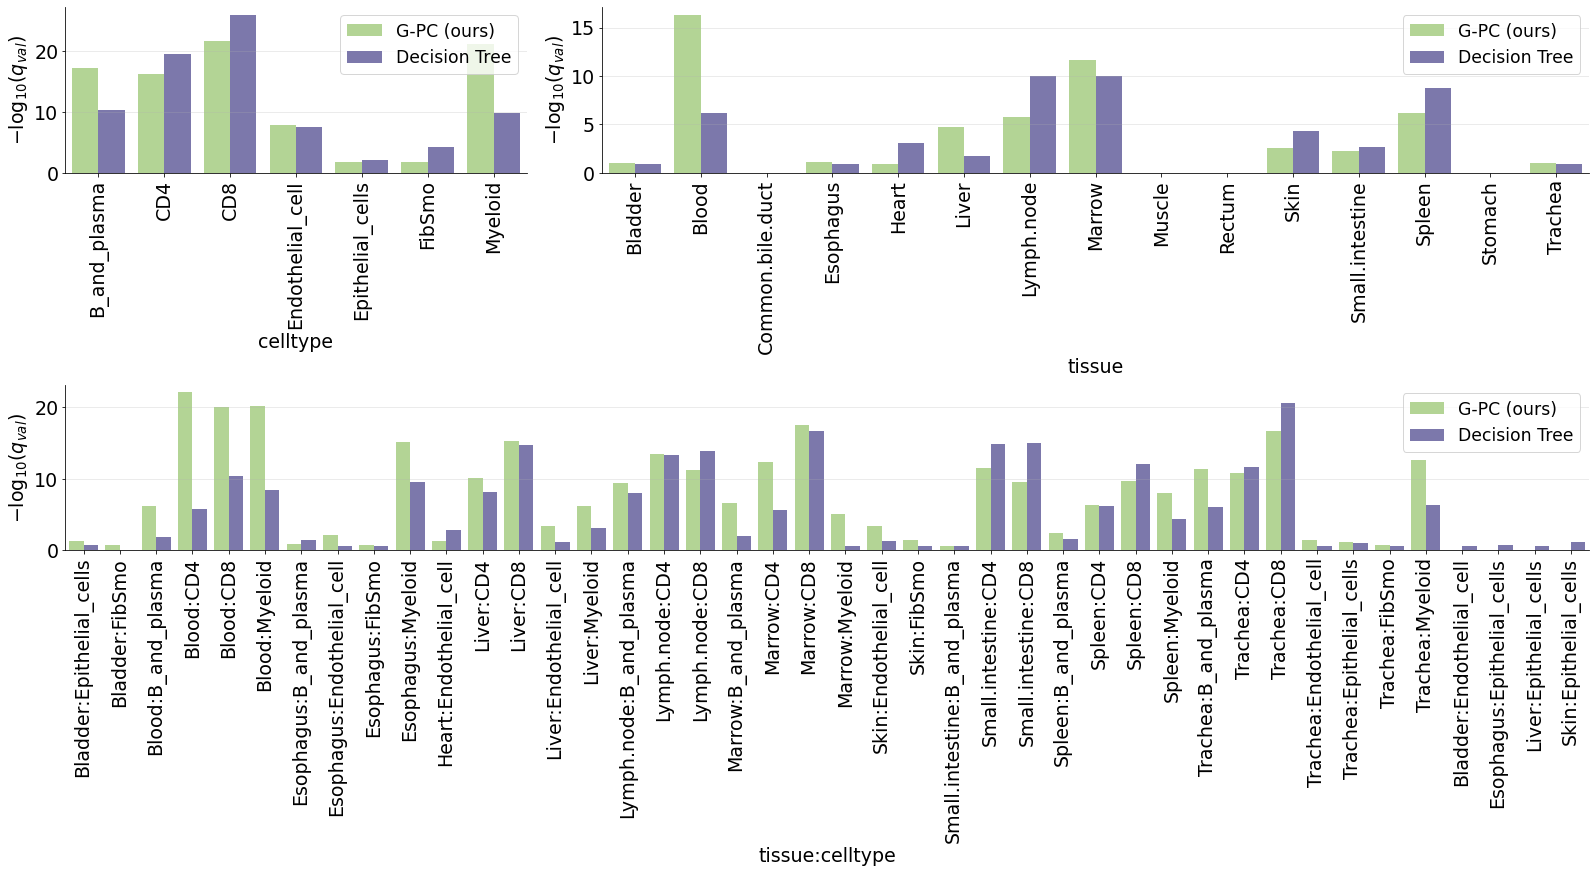

In [13]:
fig = plt.figure(constrained_layout=True)

gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:3])
ax3 = fig.add_subplot(gs[1, 0:3])

fig.set_size_inches((22, 12))

# celltype
x = 'celltype'
df = get_df(f'GPC_{x}.json', f'DT_{x}.json', x)
barplot(df, ax=ax1, x=x, palette=pal)
# tissue
x = 'tissue'
df = get_df(f'GPC_{x}.json', f'DT_{x}.json', x)
barplot(df, ax=ax2, x=x, palette=pal)
# tissue/cell type
x = 'celltype_tissue'
df = get_df(f'GPC_{x}.json', f'DT_{x}.json', x)
barplot(df, ax=ax3, x=x, palette=pal)

plt.savefig(imdir_png / 'celltype_markers.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(imdir_svg / 'celltype_markers.svg', dpi=300, transparent=True, bbox_inches='tight')

plt.show()

<h2>Plot marker membership matrix</h2>

In [34]:
genes = np.unique(np.concatenate(list(markers.values()))).tolist()
phenotypes = list(markers.keys())

In [35]:
membership = np.zeros((len(genes), len(phenotypes)), dtype=int)
for celltype, genelist in markers.items():
    i = phenotypes.index(celltype)
    for gene in genelist:
        j = genes.index(gene)
        membership[j][i] = 1
genes = np.asarray(genes)
phenotypes = np.asarray(phenotypes)

In [36]:
pal=["264653","2a9d8f","e9c46a","f4a261","e76f51"]
pal = ['#' + i for i in pal]

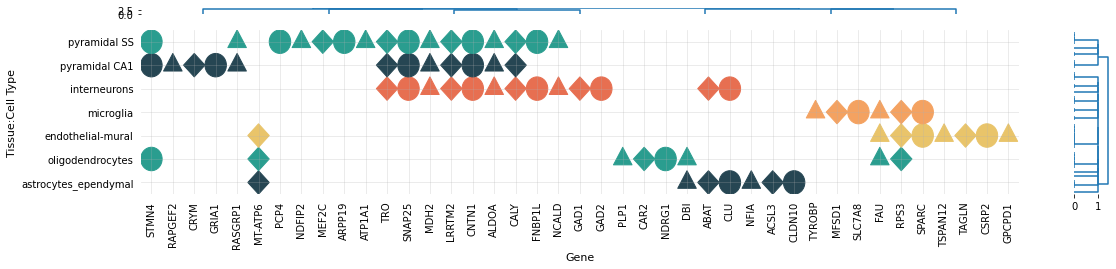

In [47]:
def get_dendro_order(mat, ax, orientation):
    despine_all(ax)
    z = linkage(mat)
    dn = dendrogram(z, orientation=orientation, ax=ax, no_labels=True, color_threshold=0)
    order = np.array(dn['ivl']).astype(int)
    return order
    

fig, axes = plt.subplots(
    nrows=2, ncols=2,
    gridspec_kw={
        'width_ratios': [25, 1],
        'height_ratios': [1, 25]
    })

gene_order = get_dendro_order(membership, axes[1][1], 'right')
phenotypes_order = get_dendro_order(membership.T, axes[0][0], 'top')
axes[0][1].remove()

fig.tight_layout()
ax = dotplot(
    membership[gene_order][:, phenotypes_order].T,
    imsize=(15, 3),
    ylabel='Tissue:Cell Type',
    xlabel='Gene',
    yticklabels=phenotypes[phenotypes_order],
    colorrow=False,
    xticklabels=genes[gene_order],
    ax=axes[1][0],
    return_fig=True,
    pal=pal,
    savepath=imdir_png / 'dendro20.png',
    savepath_svg=imdir_svg / 'dendro20.svg'
)

plt.show()